In [1]:
cd  lenstronomy-tutorials/Notebooks/Ejercicios_Juan/

/home/kingsman/Escritorio/Lenstronomy/lenstronomy-tutorials/Notebooks/Ejercicios_Juan


### Inspección del dataset

Este será el conjunto de datos con los que se entrenará al doble-autoencoder.
La primera imagen será la entrada del mismo; las otras dos serán los targets que queremos emular.

Available datasets: ['delta_psi_maps', 'images_noisy', 'images_smooth', 'subhalo_mass', 'subhalo_x', 'subhalo_y']
images_noisy shape: (300, 100, 100)
images_smooth shape: (300, 100, 100)
delta_psi_maps shape: (300, 100, 100)
subhalo_mass shape: (300,)
subhalo_x shape: (300,)
subhalo_y shape: (300,)
Plotting samples: [129   2  20]


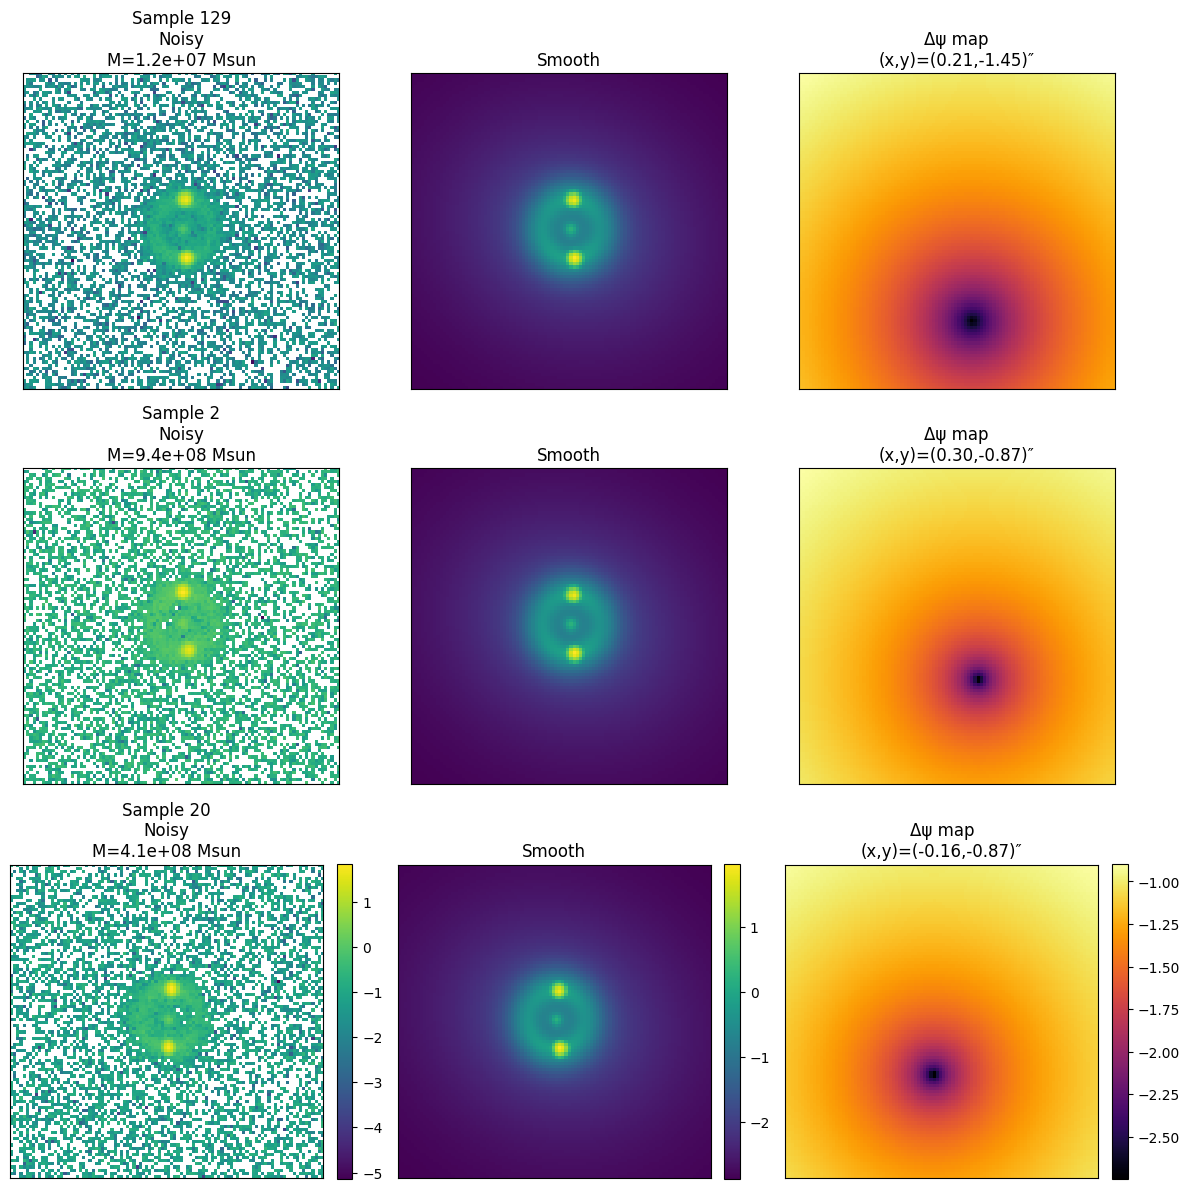

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Path to your HDF5 file
h5_path = 'lens_dataset.h5'

# Open the file and inspect
with h5py.File(h5_path, 'r') as f:
    print("Available datasets:", list(f.keys()))
    print("images_noisy shape:", f['images_noisy'].shape)
    print("images_smooth shape:", f['images_smooth'].shape)
    print("delta_psi_maps shape:", f['delta_psi_maps'].shape)
    print("subhalo_mass shape:", f['subhalo_mass'].shape)
    print("subhalo_x shape:", f['subhalo_x'].shape)
    print("subhalo_y shape:", f['subhalo_y'].shape)

    # Choose three random sample indices
    N = f['images_noisy'].shape[0]
    sample_indices = np.random.choice(N, size=3, replace=False)
    print("Plotting samples:", sample_indices)

    # Plot each sample as a row of three panels
    fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)
    for row, idx in enumerate(sample_indices):
        img_noisy   = f['images_noisy'][idx]
        img_smooth  = f['images_smooth'][idx]
        delta_psi   = f['delta_psi_maps'][idx]
        mass        = f['subhalo_mass'][idx]
        x_sub, y_sub = f['subhalo_x'][idx], f['subhalo_y'][idx]

        # Panel 1: Noisy image
        im0 = axes[row, 0].imshow(img_noisy, origin='lower', cmap='viridis')
        axes[row, 0].set_title(f"Sample {idx}\nNoisy\nM={mass:.1e} Msun")
        # Panel 2: Smooth target
        im1 = axes[row, 1].imshow(img_smooth, origin='lower', cmap='viridis')
        axes[row, 1].set_title("Smooth")
        # Panel 3: Δψ map
        im2 = axes[row, 2].imshow(delta_psi, origin='lower', cmap='inferno')
        axes[row, 2].set_title(f"Δψ map\n(x,y)=({x_sub:.2f},{y_sub:.2f})″")

        # Add colorbars only on the last row (or adjust as desired)
        if row == 2:
            fig.colorbar(im0, ax=axes[row, 0], fraction=0.046, pad=0.04)
            fig.colorbar(im1, ax=axes[row, 1], fraction=0.046, pad=0.04)
            fig.colorbar(im2, ax=axes[row, 2], fraction=0.046, pad=0.04)

    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()


### 1 The very first thing is to load & split your data into train/val/test sets—only once you have those arrays in memory can you decide on and apply your preprocessing (normalization, log‐scaling, augmentations, etc.). Here’s a sketch of the steps:

In [12]:
with h5py.File('lens_dataset.h5', 'r') as f:
    X_noisy  = f['images_noisy'][:]    # shape (N, ny, nx)
    Y_smooth = f['images_smooth'][:]   # shape (N, ny, nx)
    Y_delta  = f['delta_psi_maps'][:]  # shape (N, ny, nx)
    mass     = f['subhalo_mass'][:]    # shape (N,)
    xpos     = f['subhalo_x'][:]       # shape (N,)
    ypos     = f['subhalo_y'][:]       # shape (N,)

    # suppose X_noisy is shape (N,100,100), Y_smooth & Y_delta likewise
# add a channel axis so it becomes (N,1,100,100):
X = torch.from_numpy(X_noisy).float().unsqueeze(1)    # now (N,1,100,100)
Y1 = torch.from_numpy(Y_smooth).float().unsqueeze(1)  # (N,1,100,100)
Y2 = torch.from_numpy(Y_delta).float().unsqueeze(1)   # (N,1,100,100)

In [13]:
from sklearn.model_selection import train_test_split

# first split off test
idx = np.arange(X_noisy.shape[0])
idx_train, idx_test = train_test_split(idx, test_size=0.1, random_state=42)
# then split train into train+val
idx_train, idx_val  = train_test_split(idx_train, test_size=0.1111, random_state=42)
# 0.1111*0.9 ≈ 0.1 of total

X_train,  Y1_train,  Y2_train  = X_noisy [idx_train], Y_smooth[idx_train], Y_delta[idx_train]
X_val,    Y1_val,    Y2_val    = X_noisy [idx_val],   Y_smooth[idx_val],   Y_delta[idx_val]
X_test,   Y1_test,   Y2_test   = X_noisy [idx_test],  Y_smooth[idx_test],  Y_delta[idx_test]
mass_train, mass_val, mass_test = mass[idx_train],   mass[idx_val],   mass[idx_test]
xpos_train, xpos_val, xpos_test = xpos[idx_train],   xpos[idx_val],   xpos[idx_test]
ypos_train, ypos_val, ypos_test = ypos[idx_train],   ypos[idx_val],   ypos[idx_test]


In [14]:
# (they should already be in log space if simulate_forward returned them that way)
# but if you ever need to re-normalize to [0,1]:
def normalize(arr):
    mn, mx = arr.min(), arr.max()
    return (arr - mn) / (mx - mn)

X_train = normalize(X_train)
X_val   = normalize(X_val)
X_test  = normalize(X_test)

# (same for Y1_*, Y2_* if you want to keep all channels on [0,1])


Inputs (noisy) → mean: nan  std: nan  min: nan  max: nan
Targets smooth → mean: -2.359  std: 0.601  min: -2.879  max: 1.968
Targets Δψ    → mean: -1.460  std: 0.367  min: -2.993  max: -0.572
Subhalo mass  → min: 1.0e+07  max: 9.5e+08
Subhalo x pos → min: -2.48″  max: 2.49″
Subhalo y pos → min: -2.45″  max: 2.50″


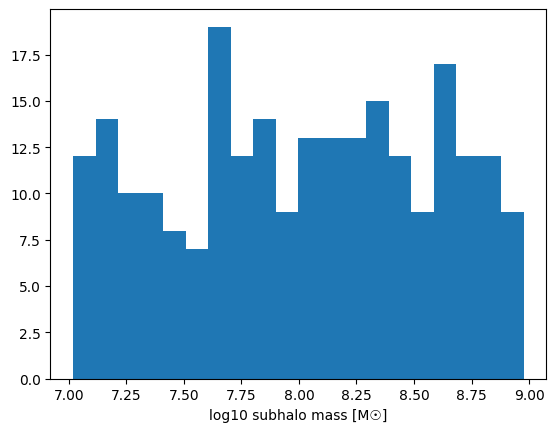

In [15]:
print("Inputs (noisy) → mean: %.3f  std: %.3f  min: %.3f  max: %.3f" % (
    X_train.mean(), X_train.std(), X_train.min(), X_train.max()))
print("Targets smooth → mean: %.3f  std: %.3f  min: %.3f  max: %.3f" % (
    Y1_train.mean(), Y1_train.std(), Y1_train.min(), Y1_train.max()))
print("Targets Δψ    → mean: %.3f  std: %.3f  min: %.3f  max: %.3f" % (
    Y2_train.mean(), Y2_train.std(), Y2_train.min(), Y2_train.max()))

print("Subhalo mass  → min: %.1e  max: %.1e" % (mass_train.min(), mass_train.max()))
print("Subhalo x pos → min: %.2f″  max: %.2f″" % (xpos_train.min(), xpos_train.max()))
print("Subhalo y pos → min: %.2f″  max: %.2f″" % (ypos_train.min(), ypos_train.max()))

plt.hist(np.log10(mass_train), bins=20)
plt.xlabel('log10 subhalo mass [M☉]')
plt.show()


In [16]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(Y1_train).float(),
    torch.from_numpy(Y2_train).float(),
)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
# Similarly for val_loader, test_loader...
val_ds = TensorDataset(
    torch.from_numpy(X_val).float(),
    torch.from_numpy(Y1_val).float(),
    torch.from_numpy(Y2_val).float(),
)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_ds = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(Y1_test).float(),
    torch.from_numpy(Y2_test).float(),
)   


In [17]:

import torch
import torch.nn as nn
import torch.nn.functional as F

# Detect device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ————————————————————————————————————————————————
# 1) Definición de las capas (funcional, sin clases propias)

# Encoder: baja la resolución de 100×100→25×25 y proyecta a un latente de 128 dims
encoder = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 1×100×100 → 16×50×50
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 16×50×50 → 32×25×25
    nn.ReLU(),
    nn.Flatten(),                                          # → 32*25*25
    nn.Linear(32*25*25, 128),                              # → 128
    nn.ReLU(),
).to(device)

# Decoder para la imagen suave (smooth)
decoder_smooth = nn.Sequential(
    nn.Linear(128, 32*25*25),                              # 128 → 32*25*25
    nn.ReLU(),
    nn.Unflatten(1, (32, 25, 25)),                         # → 32×25×25
    nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # →16×50×50
    nn.ReLU(),
    nn.ConvTranspose2d(16, 1,  kernel_size=3, stride=2, padding=1, output_padding=1),  # →1×100×100
    nn.Sigmoid(),  # asume entrada [0,1]
).to(device)

# Decoder para la corrección de potencial (delta ψ)
decoder_delta = nn.Sequential(
    nn.Linear(128, 32*25*25),
    nn.ReLU(),
    nn.Unflatten(1, (32, 25, 25)),
    nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.ReLU(),
    nn.ConvTranspose2d(16, 1,  kernel_size=3, stride=2, padding=1, output_padding=1),
    # salida en ℝ (puede ser positivo o negativo), usamos Identity
    nn.Identity(),
).to(device)

# ————————————————————————————————————————————————
# 2) Funciones puras para el flujo de datos

def encode(x):
    """Convierte batch (N,1,100,100) → latente (N,128)."""
    return encoder(x)

def decode_smooth(z):
    """Reconstruye la imagen suave desde el latente."""
    return decoder_smooth(z)

def decode_delta(z):
    """Reconstruye el mapa Δψ desde el latente."""
    return decoder_delta(z)

def reconstruct(x):
    """
    Dado x (noisy), devuelve (smooth_hat, delta_hat).
    Flujo: x → latente → dos decoders.
    """
    z = encode(x)
    return decode_smooth(z), decode_delta(z)

# ————————————————————————————————————————————————
# 3) Loop de entrenamiento (funcional)

def train_epoch(dataloader, optimizer, loss_fn, alpha=1.0):
    """
    Un epoch de entrenamiento:
    - calcula smooth_hat y delta_hat
    - aplica pérdida compuesta
    - retropropaga y optimiza
    """
    encoder.train()
    decoder_smooth.train()
    decoder_delta.train()
    total_loss = 0.0
    for imgs, targets_smooth, targets_delta in dataloader:
        imgs   = imgs.to(device)
        ts     = targets_smooth.to(device)
        td     = targets_delta.to(device)
        optimizer.zero_grad()
        pred_s, pred_d = reconstruct(imgs)
        loss = loss_fn(pred_s, ts) + alpha * loss_fn(pred_d, td)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(dataloader.dataset)

def eval_epoch(dataloader, loss_fn, alpha=1.0):
    """
    Un epoch de validación/test:
    - idéntico a train pero sin backward ni optimizer.step()
    """
    encoder.eval()
    decoder_smooth.eval()
    decoder_delta.eval()
    total_loss = 0.0
    with torch.no_grad():
        for imgs, ts, td in dataloader:
            imgs, ts, td = imgs.to(device), ts.to(device), td.to(device)
            pred_s, pred_d = reconstruct(imgs)
            loss = loss_fn(pred_s, ts) + alpha * loss_fn(pred_d, td)
            total_loss += loss.item() * imgs.size(0)
    return total_loss / len(dataloader.dataset)

# ————————————————————————————————————————————————
# 4) Ejemplo de entrenamiento básico

# Preparar DataLoader (asumiendo X_train,... ya en tensores y con shape (N,1,100,100))
# from torch.utils.data import TensorDataset, DataLoader
# train_ds = TensorDataset(X_train, Y1_train, Y2_train)
# train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
# val_loader   = DataLoader(val_ds,   batch_size=32)

optimizer = torch.optim.Adam(
    list(encoder.parameters()) +
    list(decoder_smooth.parameters()) +
    list(decoder_delta.parameters()),
    lr=1e-3
)
loss_fn = nn.MSELoss()

num_epochs = 20
for epoch in range(1, num_epochs+1):
    train_loss = train_epoch(train_loader, optimizer, loss_fn, alpha=1.0)
    val_loss   = eval_epoch(val_loader,   loss_fn, alpha=1.0)
    print(f"Epoch {epoch:02d}: train_loss = {train_loss:.4f}, val_loss = {val_loss:.4f}")



RuntimeError: Given groups=1, weight of size [16, 1, 3, 3], expected input[1, 32, 100, 100] to have 1 channels, but got 32 channels instead